# Transformer Implementation
## 순서
1. Prepare Dataset
2. Positional Embedding
3. Scale-Dot Attention
4. Multi-Head Attention
5. Masked Multi-Head Attention
6. Feed Forward Networks

### 1. Prepare Dataset
PyTorch Tutorials와 동일

In [1]:
import torch
# data
import torchtext
from torchtext.data.utils import get_tokenizer

# To use GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
TEXT = torchtext.data.Field(tokenize=get_tokenizer("basic_english"),
                            init_token='<sos>',
                            eos_token='<eos>',
                            lower=True)
train_txt, val_txt, test_txt = torchtext.datasets.WikiText2.splits(TEXT)
TEXT.build_vocab(train_txt)

In [3]:
train_txt

In [4]:
def batchify(data, bsz):
    '''
    bsz : batch_size
    '''
    data = TEXT.numericalize([data.examples[0].text])
    # 데이터셋을 bsz 파트들로 나눕니다.
    nbatch = data.size(0) // bsz
    # 깔끔하게 나누어 떨어지지 않는 추가적인 부분(나머지들) 은 잘라냅니다.
    data = data.narrow(0, 0, nbatch * bsz)
    # 데이터에 대하여 bsz 배치들로 동등하게 나눕니다.
    data = data.view(bsz, -1).t().contiguous()
    return data
#     return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_txt, batch_size)
val_data = batchify(val_txt, eval_batch_size)
test_data = batchify(test_txt, eval_batch_size)

In [5]:
bptt = 35
def get_batch(source, i):
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].view(-1)
    return data, target

In [6]:
ntokens = len(TEXT.vocab.stoi) # 단어 사전의 크기
emsize = 200 # 임베딩 차원
nhid = 200 # nn.TransformerEncoder 에서 피드포워드 네트워크(feedforward network) 모델의 차원
nlayers = 2 # nn.TransformerEncoder 내부의 nn.TransformerEncoderLayer 개수
nhead = 2 # 멀티헤드 어텐션(multi-head attention) 모델의 헤드 개수
dropout = 0.2 # 드랍아웃(dropout) 값

### 2. Embedding

2-1. Input Embedding

In [7]:
import torch.nn as nn

In [8]:
# sample
sample_data, sample_targets = get_batch(train_data, 0)

In [9]:
print((ntokens, nhid))
print(sample_data.shape)

(28785, 200)
torch.Size([35, 20])


In [10]:
embed_layer = nn.Embedding(ntokens, nhid)
input_embs = embed_layer(sample_data)
# input_embs = nn_emb(inputs) # input embedding
# print(input_embs.size())
print(input_embs.size())

torch.Size([35, 20, 200])


2-2. Positional Embedding  

\begin{equation} PE(pos;2i) = sin(pos/10000^{2i/dmodel}) \end{equation}
\begin{equation} PE(pos;2i+1) = cos(pos/10000^{2i/dmodel}) \end{equation}

* Steps
    1. Calculate angles of given position (at i ?)
    2. Calculate sine values of the angles at even index 2i
    3. Calculate cosine values of the angles at odd index 2i+1

* Input
    - nseq : embedding dimension of tokens
    - nhid : hidden size    

- ref. 
    - https://wikidocs.net/31379
    - https://inmoonlight.github.io/2020/01/26/Positional-Encoding/

In [11]:
import numpy as np

In [12]:
class PositionalEncoding:
    def __init__(self, nseq, nhid):
        # dmodel은 트랜스포머의 모든 층의 출력 차원을 의미하는 트랜스포머의 하이퍼파라미터
        self.nseq = nseq
        self.nhid = nhid
    
    def get_angle(self, pos, i_hidn):
        return pos / np.power(10000, 2 * (i_hidn // 2) / self.nhid)

    def positional_encoding(self):
        sinusoid_table = np.array([[self.get_angle(pos, i_hidn) 
                                    for i_hidn in range(self.nhid)] 
                                    for pos in range(self.nseq)])
        sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
        sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
        return sinusoid_table

In [13]:
nseq = 64   # dim of embedding
pos_encoding = PositionalEncoding(nseq, nhid).positional_encoding()

In [14]:
pos_encoding

array([[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 8.41470985e-01,  5.40302306e-01,  7.90736287e-01, ...,
         9.99999993e-01,  1.09647819e-04,  9.99999994e-01],
       [ 9.09297427e-01, -4.16146837e-01,  9.68109419e-01, ...,
         9.99999971e-01,  2.19295637e-04,  9.99999976e-01],
       ...,
       [-9.66117770e-01, -2.58101636e-01, -7.93175978e-01, ...,
         9.99973108e-01,  6.68846713e-03,  9.99977632e-01],
       [-7.39180697e-01,  6.73507162e-01, -3.99571392e-03, ...,
         9.99972219e-01,  6.79811245e-03,  9.99976893e-01],
       [ 1.67355700e-01,  9.85896582e-01,  7.88283970e-01, ...,
         9.99971315e-01,  6.90775770e-03,  9.99976141e-01]])

In [15]:
pos_encoding.shape

(64, 200)

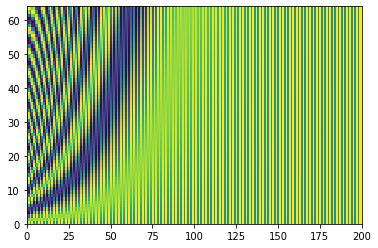

In [16]:
# visualize
import matplotlib.pyplot as plt

plt.figure()
# plt.plot(pos_encoding)
plt.pcolormesh(pos_encoding)
plt.xlim((0, nhid))
# plt.colorbar()
plt.show()

### 3. Scale-Dot Attention
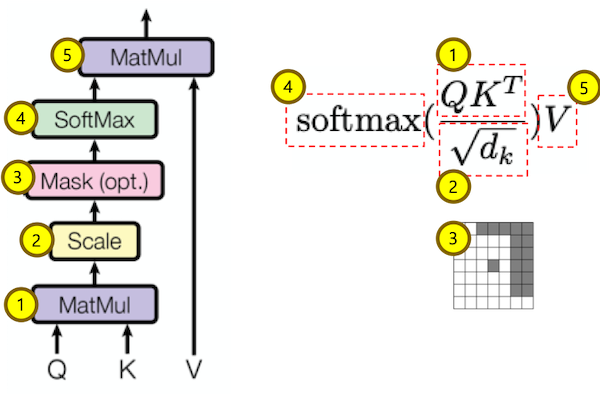

1. 위해서 구해진 position encodong 값을 이용해 position emgedding을 생성합니다.
학습되는 값이 아니므로 freeze옵션을 True로 설정 합니다.
2. 입력 inputs과 동일한 크기를 갖는 positions값을 구합니다.
3. input값 중 pad(0)값을 찾습니다.
4. positions값중 pad부분은 0으로 변경 합니다.
5. positions값에 해당하는 embedding값을 구합니다.

In [17]:
pos_encoding = torch.FloatTensor(pos_encoding)
nn_pos = nn.Embedding.from_pretrained(pos_encoding, freeze=True)

positions = torch.arange(sample_data.size(1), device=sample_data.device, dtype=sample_data.dtype) \
            .expand(sample_data.size(0), sample_data.size(1)).contiguous() + 1
pos_mask = sample_data.eq(0)

positions.masked_fill_(pos_mask, 0)
pos_embs = nn_pos(positions) # position embedding

print(sample_data[:5])
print(positions[:5])

tensor([[    3,    25,  1849,   570,     7,     5,     5,  9258,     4,    56,
             0,     7,     6,  6634,     4,  6603,     6,     5,    65,    30],
        [   12,    66,    13,  4889,   458,     8,  1045,    21, 19094,    34,
           147,     4,     0,    10,  2280,  2294,    58,    35,  2438,  4064],
        [ 3852, 13667,  2962,    68,     6, 28374,    39,   417,     0,  2034,
            29,    88, 27804,   350,     7,    17,  4811,   902,    33,    20],
        [ 3872,     5,     9,     4,   155,     8,  1669,    32,  2634,   257,
             4,     5,     5,    11,  4568,  8205,    78,  5258,  7723, 12009],
        [  884,    91,   963,   294,     4,   548,    29,   279,    37,     4,
           391,    31,     4,  2614,   948, 13583,   405,   545,    15,    16]])
tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  0, 12, 13, 14, 15, 16, 17, 18,
         19, 20],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  0, 14, 15, 16, 17, 18,
         19, 20],
      

In [18]:
print(pos_embs.size())

torch.Size([35, 20, 200])


In [19]:
input_sums = input_embs + pos_embs

In [20]:
Q = input_sums
K = input_sums
V = input_sums
attn_mask = sample_data.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))

print(attn_mask.size())
print(attn_mask[0][:5])

torch.Size([35, 20, 20])
tensor([[False, False, False, False, False, False, False, False, False, False,
          True, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
          True, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
          True, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
          True, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
          True, False, False, False, False, False, False, False, False, False]])


### 4. Multi-Head Attention
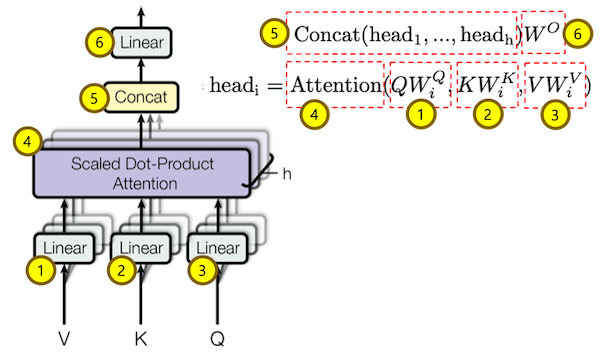

### 5. Masked Multi-Head Attention


### 6. Feed Forward Networks